# Engineering WindFarmModels

All Wind farms models take a `Site` and a `WindTurbines` object as input

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [1]:
# import and setup site and windTurbines
import numpy as np
import matplotlib.pyplot as plt
import os
import py_wake
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()
wt_x, wt_y = site.initial_position.T

![Engineering models](../_static/EngineeringModels.svg)

The engineering wind farms models in PyWake are composed of one of two wind farms models in combination with a wake deficit model, a superposition model and optionally a blockage deficit and a turbulence model.

- `WindFarmModel`: Defines the proceedure that detemines how wake and blockage deficits propagates in the wind farm. 
Two models are available:
  - `PropagateDownwind`(fast, but blockage is neglected)
  - `All2AllIterative`(slower but supports blockage).
- Wake `DeficitModel`: Calculate wake deficit from one wind turbine to downstream wind turbines or sites in the wind farm. Several common models are available: 
  - [NOJDeficit](#NOJDeficit)
  - [FugaDeficit](#FugaDeficit)
  - [BastankhahGaussianDeficit](#BastankhahGaussianDeficit)
  - [IEA37SimpleBastankhahGaussianDeficit](#IEA37SimpleBastankhahGaussianDeficit)
- `SuperpositionModel`: Defines how deficits from multiple sources sums up. Available models are:
  - [LinearSum](#LinearSum): Deficits sum up linearly
  - [SquaredSum](#SquaredSum): Deficits sum as root-sum-square
  - [MaxSum](#MaxSum): Only the largest deficit is considered
- Blockage `DeficitModel`: Calculate blockage deficit from one wind turbine to upstream wind turbines or sites in the wind farm. Available models are:
  - [FugaDeficit](#FugaDeficit)
  - [SelfSimilarityDeficit](#SelfSimilarityDeficit)
- `DeflectionModel`: Calculate deflected downwind and crosswind distances due to yaw misalignment, shear etc. Available models are:
  - [JimenezWakeDeflection](#JimenezWakeDeflection)
- `TurbulenceModel`: Calculate added turbulence in the wake from one wind turbine to downstream wind turbines or sites in the wind farm. Available models are:
  - `STF2005TurbulenceModel` (Steen Frandsen, from IEC 2005 standard)
  - `STF2017TurbulenceModel` (Steen Frandsen, from IEC 2017 standard)


## Predefined WindFarmModels
The deficit models comprise:

| Name | WindFarmModel | Wake DeficitModel | Blockage DeficitModel | SuperpositionModel | TurbulenceModel |
| :--- | :--- | :--- | :--- | :--- | :--- |
| NOJ | [PropagateDownwind](#PropagateDownwind) | [NOJDeficit](#NOJDeficit) | - | [SquaredSum](#SquaredSum) | - |
| Fuga | [PropagateDownwind](#PropagateDownwind) | [FugaDeficit](#FugaDeficit) | - | [LinearSum](#LinearSum) | - |
| FugaBlockage | [All2AllIterative](#All2AllIterative) | [FugaDeficit](#FugaDeficit) | [FugaDeficit](#FugaDeficit) | [LinearSum](#LinearSum) | - |
| BastankhahGaussian | [PropagateDownwind](#PropagateDownwind) | [BastankhahGaussianDeficit](#BastankhahGaussianDeficit) | - | [SquaredSum](#SquaredSum) | - |
| IEA37SimpleBastankhahGaussian | [PropagateDownwind](#PropagateDownwind) | [IEA37SimpleBastankhahGaussianDeficit](#IEA37SimpleBastankhahGaussianDeficit) | - | [SquaredSum](#SquaredSum) | - |

In [2]:
from py_wake import NOJ
from py_wake import Fuga
from py_wake import FugaBlockage
from py_wake import BastankhahGaussian
from py_wake import IEA37SimpleBastankhahGaussian

# Path to Fuga look-up tables
lut_path = os.path.dirname(py_wake.__file__)+'/tests/test_files/fuga/2MW/Z0=0.03000000Zi=00401Zeta0=0.00E+0/'

models = {'NOJ': NOJ(site,windTurbines), 
          'Fuga': Fuga(lut_path,site,windTurbines),
          'FugaBlockage': FugaBlockage(lut_path,site,windTurbines), 
          'BGaus': BastankhahGaussian(site,windTurbines),
          'IEA37BGaus': IEA37SimpleBastankhahGaussian(site,windTurbines)
         }

These models can easily be combined with other models, e.g. NOJ with linear sum superposition:

In [3]:
from py_wake.superposition_models import LinearSum
models['NOJLinear'] = NOJ(site,windTurbines,superpositionModel=LinearSum())

or models can be combined in custom ways, e.g. NOJDeficit for the wake, LinearSum superposition and SelfSimilarityDeficit for the blockage:

In [4]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.deficit_models import NOJDeficit, SelfSimilarityDeficit
models['NOJ_ss'] = All2AllIterative(site,windTurbines,
                                          wake_deficitModel=NOJDeficit(),
                                          superpositionModel=LinearSum(), 
                                          blockage_deficitModel=SelfSimilarityDeficit() )

In [5]:
for name, model in models.items():
    print ("%s: %s"%(name, model))

NOJ: NOJ(PropagateDownwind, NOJDeficit-wake, SquaredSum-superposition)
Fuga: Fuga(PropagateDownwind, FugaDeficit-wake, LinearSum-superposition)
FugaBlockage: FugaBlockage(All2AllIterative, FugaDeficit-wake, FugaDeficit-blockage, LinearSum-superposition)
BGaus: BastankhahGaussian(PropagateDownwind, BastankhahGaussianDeficit-wake, SquaredSum-superposition)
IEA37BGaus: IEA37SimpleBastankhahGaussian(PropagateDownwind, IEA37SimpleBastankhahGaussianDeficit-wake, SquaredSum-superposition)
NOJLinear: NOJ(PropagateDownwind, NOJDeficit-wake, LinearSum-superposition)
NOJ_ss: All2AllIterative(EngineeringWindFarmModel, NOJDeficit-wake, SelfSimilarityDeficit-blockage, LinearSum-superposition)


## Engineering WindFarmModel base classes

### PropagateDownwind
The `PropagateDownwind` wind farm model is very fast as it only performs a minimum of deficit calculations. It iterates over all turbines in downstream order. In each iteration it calculates the effective wind speed at the current wind turbine as the free stream wind speed minus the sum up the deficit from upstream sources. Based on this effective wind speed, it calculates the deficit caused by the current turbine on all downstream destinations. Note, that this procedure neglects upstream blockage effects.

```python

for wt in wind turbines in downstream order:
    ws_eff[wt] = ws[wt] - superposition(deficit[from_upstream_src,to_wt])
    ct = windTurbines.ct(ws_eff[wt])
    deficit[from_wt,to_downstream_dst] = wakeDeficitModel(ct, distances[from_wt,to_downstream_dst], ...)
```


In [6]:
%%timeit -r1
# simulate with 20 wind turbines, 360 wind directions and 23 wind speeds
models['Fuga'](wt_x[:20],wt_y[:20])

102 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


### All2AllIterative
The `All2AllIterative` wind farm model is slower but is capable of handling blockage effects. <br/> 
It iterates until the effective wind speed converge (i.e. less than or equal to the maximum number of turbines that affect each other in the wind farm. The converge tolerance is an input parameter).<br/> 
In each iteration it sums up the deficit from all wind turbine sources and calculates the deficit caused by the all wind turbines turbine on all wind turbines.

```python

while ws_eff not converged:
    ws_eff[all] = ws[all] - superposition(deficit[from_all,to_all])
    ct[all] = windTurbines.ct(ws_eff[all])
    deficit[from_all,to_all] = wakeDeficitModel(ct[all], distances[from_all,to_all], ...)
```


In [7]:
%%timeit -r1
# simulate with 20 wind turbines, 360 wind directions and 23 wind speeds
models['FugaBlockage'](wt_x[:20],wt_y[:20])

3.79 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Deficit models
The deficit models models the wake and/or blockage deficit cause by a single wind turbine. 

**Variable suffixes**

The implementation of the deficit models is highly vectorized and therefore suffixes are used to indicate the dimension of variables. The suffixes used in this context are:

- i: source wind turbines
- j: destination wind turbines
- k: wind speeds
- l: wind directions

This means that `deficit_ijlk[0,1,2,3]` holds the deficit caused by the first turbine on the second turbine for the third  wind direction and fourth wind speed

In [8]:
# methods to plot deficit map, used below to visualize and compare the deficit models

import numpy as np
import matplotlib.pyplot as plt
D = 80
def deficit_map(deficitModel, xy=None):
    X, Y = np.meshgrid(*xy)
    x_j, y_j = X.flatten(), Y.flatten()
    downwind_distance_ijlk = x_j.reshape((1, -1, 1, 1))
    crosswind_distance_ijlk = np.abs(y_j.reshape((1, -1, 1, 1)))
    ws = 10
    zeros_ijl = np.zeros(crosswind_distance_ijlk.shape[:3])
    deficit_ijlk = deficitModel.calc_deficit(
        # specify arguments for all models
        WS_ilk=np.array([[[ws]]]),  # wind speed at source turbine
        D_src_il=np.array([[D]]),  # diameter of source turbine
        D_dst_ijl=None,  # diameter of destination turbine
        h_il=np.array([[67]]),  # source turbine hub height
        dw_ijlk=downwind_distance_ijlk,  # down wind distance
        hcw_ijlk=crosswind_distance_ijlk,  # horizontal cross wind distance
        dh_ijl=np.array(zeros_ijl),
        # height difference(vertical cross wind distance) between source and destination turbine
        cw_ijlk=crosswind_distance_ijlk,  # cross wind distance (both horizontal and vertical)
        ct_ilk=np.array([[[8 / 9]]]),  # thrust coefficient
        WS_eff_ilk=np.array([[[ws]]]),  # effective wind speed at source turbine
    )
    return X / D, Y / D, deficit_ijlk[0, :, 0, 0].reshape(X.shape)

    
def plot_deficit_map(deficitModel):
    xy = np.linspace(-200,500,200), np.linspace(-200,200,200)
    X,Y,deficit = deficit_map(deficitModel, xy)
    c = plt.contourf(X,Y,deficit, levels=100, cmap='Blues')
    plt.colorbar(c, label="Deficit [m/s]")
    plt.plot([0,0],[-1/2,1/2],'k')
    plt.ylabel("Crosswind distance [y/D]")
    plt.xlabel("downwind distance [x/D]")

### NOJDeficit

The NOJDeficit model is implemented according to Niels Otto Jensen, "A note on wind generator interaction." (1983), i.e. a top-hat wake, only valid in the far wake


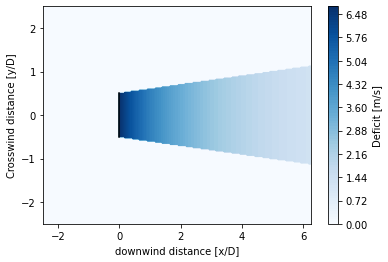

In [9]:
from py_wake.deficit_models import NOJDeficit
plot_deficit_map(NOJDeficit())

### FugaDeficit

The FugaDeficit model calculates the wake deficit based on a set op look-up tables, which must be created in advance using the [Fuga GUI](https://orbit.dtu.dk/en/publications/developments-of-the-offshore-wind-turbine-wake-model-fuga)

The fugaDeficit models both near wake, far wake and blockage deficit

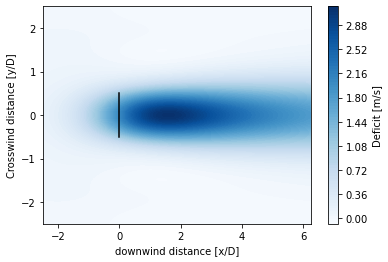

In [10]:
import os
import py_wake
from py_wake.deficit_models import FugaDeficit

# Path to Fuga look-up tables
lut_path = os.path.dirname(py_wake.__file__)+'/tests/test_files/fuga/2MW/Z0=0.03000000Zi=00401Zeta0=0.00E+0/'

plot_deficit_map(FugaDeficit(lut_path))

### BastankhahGaussianDeficit

The `BastankhahGaussianDeficit` model is implemented according to Bastankhah M and Porté-Agel F. "A new analytical model for wind-turbine wakes" J. Renew. Energy. 2014;70:116-23. The model is valid in the far wake only.

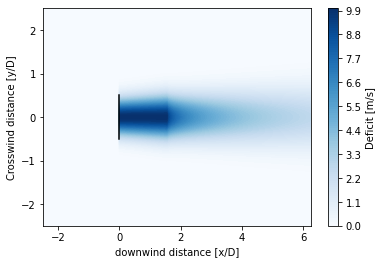

In [11]:
from py_wake.deficit_models import BastankhahGaussianDeficit
plot_deficit_map(BastankhahGaussianDeficit())

### IEA37SimpleBastankhahGaussianDeficit

The `IEA37SimpleBastankhahGaussian` model is implemented according to the [IEA task 37 documentation](https://github.com/byuflowlab/iea37-wflo-casestudies/blob/master/cs1-2/iea37-wakemodel.pdf) and is equivalent to BastankhahGaussian for $beta=1/\sqrt{8} \sim ct=0.9637188$. The model is valid in the far wake only.

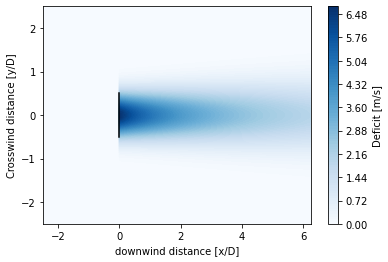

In [12]:
from py_wake.deficit_models import IEA37SimpleBastankhahGaussianDeficit
plot_deficit_map(IEA37SimpleBastankhahGaussianDeficit())

### SelfSimilarityDeficit
Simple inductionmodel model, see https://onlinelibrary.wiley.com/doi/full/10.1002/we.2137

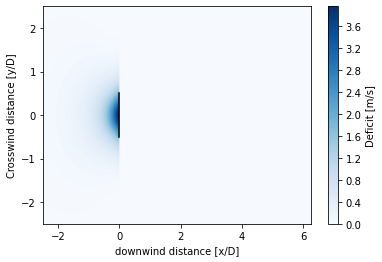

In [13]:
from py_wake.deficit_models import SelfSimilarityDeficit
plot_deficit_map(SelfSimilarityDeficit())

### Compare deficit models

In [14]:
deficitModels = [NOJDeficit(),
                 FugaDeficit(lut_path),
                 BastankhahGaussianDeficit(),
                 IEA37SimpleBastankhahGaussianDeficit(),
                 SelfSimilarityDeficit()]

**Deficit along center line**

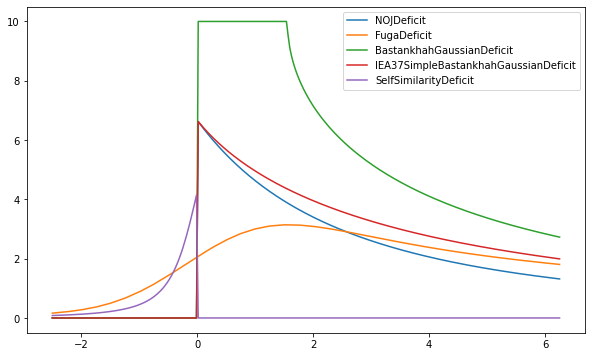

In [15]:
plt.figure(figsize=((10,6)))
for deficitModel in deficitModels:
    X, Y, deficit = deficit_map(deficitModel, xy=(np.linspace(-200,500,300), 0))
    plt.plot(X[0], deficit[0], label=deficitModel.__class__.__name__)

plt.legend()

**Deficit profile 2D downstream**

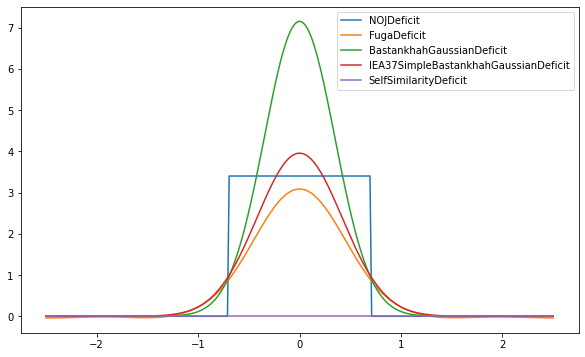

In [16]:
plt.figure(figsize=((10,6)))
for deficitModel in deficitModels:
    X, Y, deficit = deficit_map(deficitModel, xy=(2*D, np.linspace(-200,200,300)))
    plt.plot(Y[:,], deficit[:,0], label=deficitModel.__class__.__name__)

plt.legend()

### Implement your own deficit models
Deficit models must subclass `DeficitModel`and thus must implement the `calc_deficit` method and a class variable, `args4deficit` specifying the arguments required by its `calc_deficit` method

```python 
class DeficitModel(ABC):
    args4deficit = ['WS_ilk', 'dw_ijlk']

    @abstractmethod
    def calc_deficit(self):
        """Calculate wake deficit caused by the x'th most upstream wind turbines
        for all wind directions(l) and wind speeds(k) on a set of points(j)

        This method must be overridden by subclass

        Arguments required by this method must be added to the class list
        args4deficit

        See class documentation for examples and available arguments

        Returns
        -------
        deficit_ijlk : array_like
        """
```

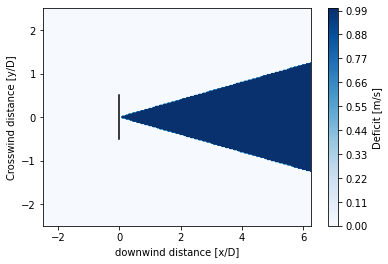

In [17]:
from py_wake.deficit_models import DeficitModel
from numpy import newaxis as na
class MyDeficitModel(DeficitModel):
    args4deficit = ['WS_ilk', 'dw_ijlk', 'cw_ijlk']

    def calc_deficit(self, WS_ilk, dw_ijlk, cw_ijlk,**_):
        # 10% deficit in downstream triangle
        ws_10pct_ijlk = 0.1*WS_ilk[:,na]
        triangle_ijlk = ((.2*dw_ijlk) >cw_ijlk)
        return ws_10pct_ijlk *triangle_ijlk

plot_deficit_map(MyDeficitModel())


## Superposition models
The super position models calculates the effective wind speed given the local wind speed and deficits (typically from multiple sources)

### LinearSum

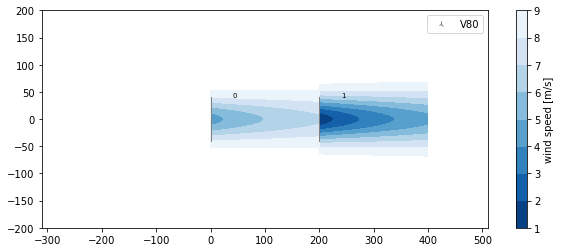

In [57]:
linear_sum = IEA37SimpleBastankhahGaussian(site, windTurbines, superpositionModel=LinearSum())
plt.figure(figsize=(10,4))
linear_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(1,10))

### SquaredSum

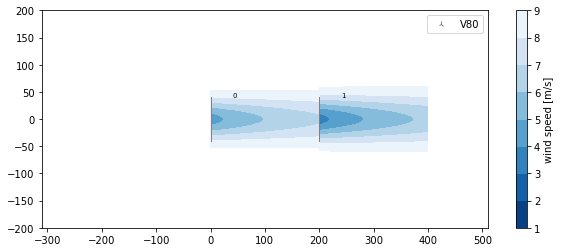

In [58]:
from py_wake.superposition_models import SquaredSum
squared_sum = IEA37SimpleBastankhahGaussian(site, windTurbines, superpositionModel=SquaredSum())
plt.figure(figsize=(10,4))
squared_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(1,10))

### MaxSum

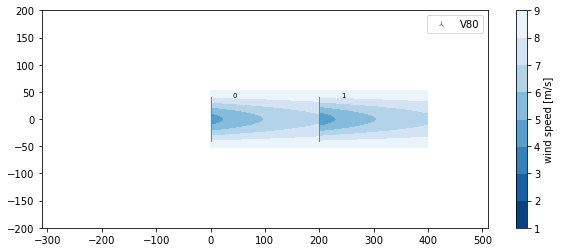

In [60]:
from py_wake.superposition_models import MaxSum
max_sum = IEA37SimpleBastankhahGaussian(site, windTurbines, superpositionModel=MaxSum())
plt.figure(figsize=(10,4))
max_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(1,10))

## Deflection models
The deflection models calculate the deflection of the wake due to yaw-misalignment, sheared inflow etc.
The deflection models take as input the downwind and crosswind distances between the source wind turbines and the destination wind turbines/sites and calculate a new set of deflected downwind and crosswind distances.

### JimenezWakeDeflection

The `JimenezWakeDeflection` model is implemented according to Jiménez, Á., Crespo, A. and Migoya, E. (2010), Application of a LES technique to characterize the wake deflection of a wind turbine in yaw. Wind Energ., 13: 559-572. doi:10.1002/we.380

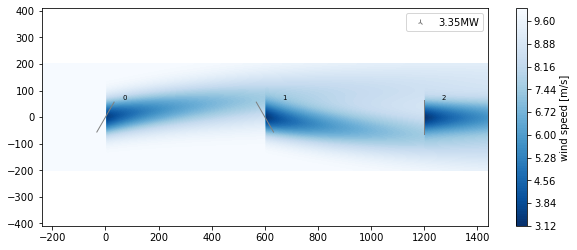

In [6]:
from py_wake import IEA37SimpleBastankhahGaussian
from py_wake.deflection_models import JimenezWakeDeflection
from py_wake.examples.data.iea37._iea37 import IEA37Site, IEA37_WindTurbines

site = IEA37Site(16)
x, y = [0, 600, 1200], [0, 0, 0]  # site.initial_position[:2].T
windTurbines = IEA37_WindTurbines()
iea_deflection = IEA37SimpleBastankhahGaussian(site, windTurbines, deflectionModel=JimenezWakeDeflection())

yaw_ilk = np.reshape([-30,30,0],(3,1,1))

plt.figure(figsize=(10,4))
iea_deflection(x, y, yaw_ilk=yaw_ilk, wd=270, ws=10).flow_map().plot_wake_map()


### Implement your own deflection models

Deficit models must subclass `DeficitModel` and thus must implement the `calc_deflection` method and a class variable, `args4deflection` specifying the arguments required by its calc_deflection method

```python

class DeflectionModel(ABC):
    args4deflection = ["ct_ilk"]

    @abstractmethod
    def calc_deflection(self, dw_ijl, hcw_ijl, **kwargs):
        """Calculate deflection

        This method must be overridden by subclass

        Arguments required by this method must be added to the class list
        args4deflection

        See documentation of EngineeringWindFarmModel for a list of available input arguments

        Returns
        -------
        dw_ijlk : array_like
            downwind distance from source wind turbine(i) to destination wind turbine/site (j)
            for all wind direction (l) and wind speed (k)
        hcw_ijlk : array_like
            horizontal crosswind distance from source wind turbine(i) to destination wind turbine/site (j)
            for all wind direction (l) and wind speed (k)
        """
```

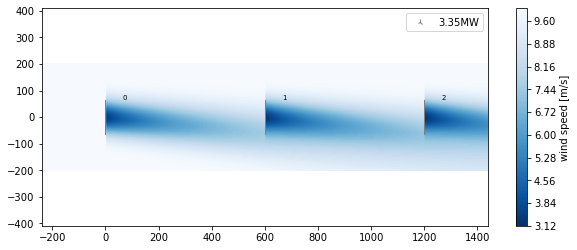

In [15]:
from py_wake.deflection_models import DeflectionModel
from numpy import newaxis as na
class MyDeflectionModel(DeflectionModel):
    args4deficit = ['dw_ijlk', 'cw_ijlk']

    def calc_deflection(self, dw_ijl, hcw_ijl, **_):
        dw_ijlk = dw_ijl[..., na] # add extra wind speed dimension
        hcw_ijlk =hcw_ijl[..., na] + .1*dw_ijlk # deflect 1/10 of the downstream distance
        return dw_ijlk, hcw_ijlk

iea_my_deflection = IEA37SimpleBastankhahGaussian(site, windTurbines, deflectionModel=MyDeflectionModel())

plt.figure(figsize=(10,4))
iea_my_deflection(x, y, wd=270, ws=10).flow_map().plot_wake_map()
